<a href="https://colab.research.google.com/github/dimitrod/ehu_atai_strawberry/blob/main/DQN_n_Step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization**

## Install dependencies

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt-get update
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium[classic_control]
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,629 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,469 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,548

## Import Dependencies

In [2]:
import os
from typing import Dict, List, Tuple
import math, random

import gym
import gymnasium as gymnasium
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import base64
import glob
import io
import os


import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F


from IPython.display import HTML, display, clear_output



#**Implementation**

## **Show recorded video**
The following functions are used in order to show in a video the obtained results

In [3]:
def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))

def remove_videos (video_folder: str):
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    for video in list_of_files:
      try:
          os.remove(video)
      except:
          print("Error while deleting file : ", video)

def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file

def show_all_videos(video_folder: str) -> str:
    """Show all the videos recorded."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    for video in list_of_files:
      ipython_show_video(video)
    print("Played:", video)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Autograd Variable

In [4]:
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs)

## Replay Buffer

In [16]:
from collections import deque

class ReplayBufferNStep:
    def __init__(self, capacity, n_step, gamma):
        self.buffer = deque(maxlen=capacity)  # Main buffer for replay
        self.n_step_buffer = deque(maxlen=n_step)  # Temporary n-step buffer
        self.n_step = n_step
        self.gamma = gamma  # Discount factor

    def _calculate_n_step_return(self):
        #Calculate the n-step return and extract the final next state and done flag.
        reward, next_state, done = 0.0, None, False
        for idx, (_, _, r, ns, d) in enumerate(self.n_step_buffer):
            reward += (self.gamma ** idx) * r  # Discounted reward
            next_state = ns  # Update next_state to the last step's state
            done = d  # Update done flag to the last step's done
            if d:  # Stop if terminal state is encountered
                next_state = None
                break
        return reward, next_state, done

    def push(self, state, action, reward, next_state, done):
        # Add transition to n-step buffer
        self.n_step_buffer.append((state, action, reward, next_state, done))

        # If n-step buffer is full, calculate n-step return and push to the main buffer
        if len(self.n_step_buffer) == self.n_step:
            state, action, _, _, _ = self.n_step_buffer[0]  # Take initial state and action
            reward, next_state, done = self._calculate_n_step_return()
            state      = np.expand_dims(state, 0)
            next_state = np.expand_dims(next_state, 0)
            self.buffer.append((state, action, reward, next_state, done))

        elif done or (len(self.n_step_buffer) < self.n_step and len(self.n_step_buffer) != 0):
            # If the episode ends or we have only one step left to fill the buffer, store the partial transition
            state, action, _, _, _ = self.n_step_buffer[0]  # Take initial state and action
            reward, next_state, done = self._calculate_n_step_return()
            state = np.expand_dims(state, 0)
            next_state = np.expand_dims(next_state, 0)
            self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        #Sample a batch of transitions from the main buffer.
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

*###* Testing Replay Buffer

In [6]:
# Create a Replay Buffer with capacity 5, n-step=3, and gamma=0.99
rB = ReplayBufferNStep(capacity=5, n_step=3, gamma=0.99)

# Add 10 transitions to the buffer
for i in range(10):
    # Simulate terminal states every 6 steps
    done = (i % 6 == 5)
    rB.push(state=i, action=i + 1, reward=1.0, next_state=i + 1, done=done)

# Check the buffer content after adding transitions
print(f"Replay Buffer Content (len={len(rB)}):")
for item in rB.buffer:
    print(item)

# Sample two experiences
try:
    mini_batch = rB.sample(2)
    print("\nSampled Mini-Batch (2 samples):", mini_batch)
except ValueError as e:
    print("\nError during sampling:", e)

# Sample three experiences
try:
    mini_batch = rB.sample(3)
    print("\nSampled Mini-Batch (3 samples):", mini_batch)
except ValueError as e:
    print("\nError during sampling:", e)

Replay Buffer Content (len=5):
(array([3]), 4, 2.9701, array([6]), True)
(array([4]), 5, 1.99, array([6]), True)
(array([5]), 6, 1.0, array([6]), True)
(array([6]), 7, 2.9701, array([9]), False)
(array([7]), 8, 2.9701, array([10]), False)

Sampled Mini-Batch (2 samples): (array([7, 3]), (8, 4), (2.9701, 2.9701), array([10,  6]), (False, True))

Sampled Mini-Batch (3 samples): (array([5, 6, 4]), (6, 7, 5), (1.0, 2.9701, 1.99), array([6, 9, 6]), (True, False, True))


## Cart Pole Environment

In [7]:
env_id = "CartPole-v0"
env = gymnasium.make(env_id, render_mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [8]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

## Epsilon greedy exploration
Epsilon value is dynamic. It starts with 1.0 value (exploration) and little by little it is going to decay until 0.01 (exploitation)

In [9]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

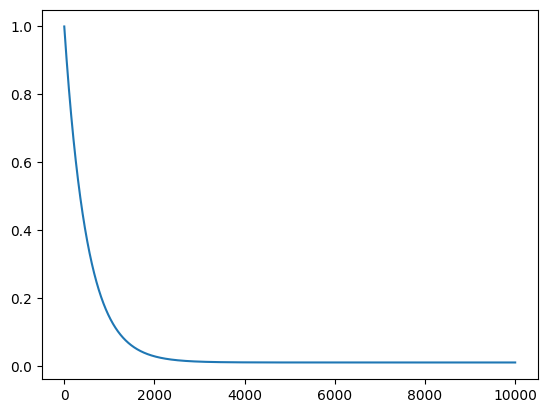

In [10]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

## Deep Q Network

In [11]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions, n_step=3, gamma=0.99):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )


        self.optimizer = optim.Adam(self.parameters())
        self.n_step = n_step
        self.gamma = gamma

        self.replay_buffer = ReplayBufferNStep(1000, n_step=n_step, gamma=gamma)
        self.batch_size = 32

    # This method defines the epsilon value. It started with 1.0 and it decays until 0.01 value
    def get_epsilon_value(self, frame_idx):
      epsilon_start = 1.0
      epsilon_final = 0.01
      epsilon_decay = 500

      epsilon = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
      return epsilon(frame_idx)

    # This method computes output Tensors from input Tensors. That is, given an state it returns an array with q(s,a) values for all actions
    def forward(self, x):
        return self.layers(x)

    # Given a state and epsilon value, this method returns an action following epsilon-greedy
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

    # Given a model, it copyes the current model on it.
    def update_target(self, target_model):
      target_model.load_state_dict(self.state_dict())

    # This method updates the weights
    # It is solved using tensors
    # def compute_td_loss(self, target_model):
    #   state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

    #   state      = Variable(torch.FloatTensor(np.float32(state)))
    #   next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    #   action     = Variable(torch.LongTensor(action))
    #   reward     = Variable(torch.FloatTensor(reward))
    #   done       = Variable(torch.FloatTensor(done))

    #   q_values      = self.forward(state)
    #   next_q_values = self.forward(next_state)
    #   next_q_state_values = target_model(next_state)

    #   q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    #   next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    #   #next_q_value = next_q_state_values.max(1)[0]
    #   expected_q_value = reward + self.gamma * next_q_value * (1 - done)

    #   loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()

    #   self.optimizer.zero_grad()
    #   loss.backward()
    #   self.optimizer.step()

    #   return loss

    # TODO
    # This method updates the weights
    def compute_td_loss_our(self, target_model):
      # Obtain a mini_batch to train the weights.
      # state, action, reward, next_state and done are numpy arrays, each position corresponds to one experience
      state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

      # Convert those numpy arrays to tensors. It is neccesary to work with Pytorch
      states_tensor      = Variable(torch.FloatTensor(np.float32(state)))       # current_state S
      actions_tensor     = Variable(torch.LongTensor(action))                   # action A
      next_states_tensor = Variable(torch.FloatTensor(np.float32(next_state)))  # next_state S'

      # The approximated q_values of each current state
      q_values_tensor      = self.forward(states_tensor) # Q(S, A, W)

      # The approximated q_values of each next state calculated with the current_model and the target_model
      next_q_values_current_model_tensor = self.forward(next_states_tensor) # Q(S', A', W)
      next_q_values_target_model_tensor = target_model.forward(next_states_tensor) # Q(S', A', W')

      # Convert the approximated next_states' q_values to numpy array. We are going to work with these arrays
      next_q_values_current_model = next_q_values_current_model_tensor.detach().numpy();
      next_q_values_target_model = next_q_values_target_model_tensor.detach().numpy();
      expected_q_value = np.zeros(self.batch_size)

      # TODO
      # input: next_q_values_current_model is a numpy array. In each element are stored all the approximated q values for the next state calculated with the current_model
      # input: next_q_values_target_model is a numpy array. In each element are stored all the approximated q values for the next state calculated with the target_model
      # input: reward is a numpy array with the rewards obtained in each experience of the mini_batch (batch_size)
      # output: expected_q_value is a numpy array. You have to store in each position the target value of each experience using next_q_values_target_model and reward elements
      # note: all these numpy arrays has the same length: the length of the mini_batch (batch_size)
      #
      # for all the elements on the batch size
      #  calculate the target expected value and store in expected_q_value

      for i in range(self.batch_size):
        next_q_value = 0
        if not(done[i]):
          next_q_value = max(next_q_values_target_model[i])

          # with current model
          #next_q_value = max(next_q_values_current_model[i])

          # with current model action and target model approximation
          #next_action = np.argmax(next_q_values_current_model[i])
          #next_q_value = next_q_values_target_model[i][next_action]

        expected_q_value[i] = reward[i] + self.gamma*next_q_value

      # END TODO

      # Prepare data for the loss function
      q_value = q_values_tensor.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
      expected_q_values = torch.tensor(expected_q_value)

      # Loss function: to know how good the weights are
      lossMSE = nn.MSELoss()
      loss = lossMSE(q_value.float(), expected_q_values.float())

      # Based on the results of the loss function, the weights are updated with gradient descent
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      return loss

    # TODO
    # Method to train the agent
    def train(self, env):
      num_frames = 25000
      losses = []
      all_rewards = []
      episode_reward = 0
      target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
      state, info = env.reset()

      # Use 3 deques
      # 1 for states at most n elements (3 e.g.)
      # 1 for actions
      # 1 for rewardsr

      # TODO
      # replay buffer attribute is empty
      # for each frame
      #   get current epsilon
      #   get action following epsilon greedy
      #   get next_state and reward
      #   add new experience to the replay buffer
      #   update state
      #   update episode total reward
      #   if done
      #     reset environment
      #     append the episode total reward to all_rewards array
      #     set episode total reward to 0
      #   if experience replay has more elements than batch_size
      #     update the weights
      #   every 100 frames update the target model

      for frame_idx in range(1, num_frames + 1):
          epsilon = self.get_epsilon_value(frame_idx)
          action = self.act(state, epsilon)

          next_state, reward, done, truncated, info = env.step(action)
          self.replay_buffer.push(state, action, reward, next_state, done)

          state = next_state
          episode_reward += reward

          if done or truncated:
              state, info = env.reset()
              all_rewards.append(episode_reward)
              episode_reward = 0

          if len(current_model.replay_buffer) > self.batch_size:
              loss = self.compute_td_loss_our(target_model)
              losses.append(loss.data)

          # to visualize how the agent is learning
          if frame_idx % 200 == 0:
              plot(frame_idx, all_rewards)

          if frame_idx % 100 == 0:
              self.update_target(target_model)

    # This method runs one episode and generates a video to observe the result
    def test(self,env):
        video_folder="videos"

        remove_videos(video_folder=video_folder)

        # we are going to work over envVideo.
        envVideo = gymnasium.wrappers.RecordVideo(env, video_folder=video_folder)

        done = False #It is used to control if the episode is finished, if it is finished the environment must be reset
        state, info = envVideo.reset()

        total_reward = 0
        while not(done):
            action = self.act(state, 0)
            next_state, reward, done, truncated, info = envVideo.step(action)
            state = next_state
            total_reward +=reward
            if done or truncated:
              break
        envVideo.close()
        print("rew: ", total_reward)
        show_all_videos(video_folder=video_folder)



### Train the agent

In [22]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
current_model.train(env)

KeyboardInterrupt: 

### Test the agent

In [ ]:
current_model.test(env)